<a href="https://colab.research.google.com/github/NicoloApolloni/Master/blob/main/CNN_ImageClassification_Apolloni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importazione Dataset

Upload file 'kaggle.json' (download it as a token from settings in your kaggle's profile)

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
#ls -a /root/.kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset
!unzip  /content/breast-ultrasound-images-dataset.zip
# ls -la ./Dataset_BUSI_with_GT/benign
# ls -la ./Dataset_BUSI_with_GT/malignant
# ls -la ./Dataset_BUSI_with_GT/normal

Saving kaggle.json to kaggle.json
100% 194M/195M [00:09<00:00, 23.8MB/s]
100% 195M/195M [00:09<00:00, 21.1MB/s]
Archive:  /content/breast-ultrasound-images-dataset.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_

# Importazione librerie

In [ ]:
import os
import random
import warnings
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import albumentations as alb
from PIL import Image
from pathlib import Path
from keras import Sequential
from keras.preprocessing import image
from keras.utils import image_dataset_from_directory, plot_model
from keras.layers import (Input, Rescaling, Conv2D, Flatten,
                          Dense, Dropout, MaxPool2D, RandomFlip,
                          RandomRotation, RandomZoom, RandomContrast,
                          RandomBrightness, RandomCrop, Lambda)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger, EarlyStopping
from tensorflow.keras.applications import vgg16, ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, fbeta_score, make_scorer

# Esplorazione Dataset

In [ ]:
benign_files = os.listdir("/content/Dataset_BUSI_with_GT/benign")
malignant_files = os.listdir("/content/Dataset_BUSI_with_GT/malignant")
normal_files = os.listdir("/content/Dataset_BUSI_with_GT/normal")

In [ ]:
# Esplorazione numero file per ogni cartella (benign, malignant, normal)
print(f'Nella cartella benign ci sono: {len(benign_files)} files')
print(f'Nella cartella malignant ci sono: {len(malignant_files)} files')
print(f'Nella cartella normal ci sono: {len(normal_files)} files')
# Conotare solo i file in formato '.png'
print(f'Nella cartella benign ci sono: {len([file_ for file_ in benign_files if file_.endswith(".png")])} files in formato ".png"')
print(f'Nella cartella malignant ci sono: {len([file_ for file_ in malignant_files if file_.endswith(".png")])} files in formato ".png"')
print(f'Nella cartella normal ci sono: {len([file_ for file_ in normal_files if file_.endswith(".png")])} files in formato ".png"')

# Benign
# Contare file mask, mask_1 e mask_2
print(f'Nella cartella benign ci sono: {len([file_ for file_ in benign_files if file_.endswith("_mask.png")])} files "_mask.png"')
print(f'Nella cartella benign ci sono: {len([file_ for file_ in benign_files if file_.endswith("_mask_1.png")])} files "_mask_1.png"')
print(f'Nella cartella benign ci sono: {len([file_ for file_ in benign_files if file_.endswith("_mask_2.png")])} files "_mask_2.png"')
# TOT file mask
print(f'Nella cartella benign ci sono: {len([file_ for file_ in benign_files if any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])])} files MASK in totale')
# TOT file no mask
print(f'Nella cartella benign ci sono: {len([file_ for file_ in benign_files if not any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])])} files NO_MASK in totale')

# Malignant
# Contare file mask, mask_1 e mask_2
print(f'Nella cartella malignant ci sono: {len([file_ for file_ in malignant_files if file_.endswith("_mask.png")])} files "_mask.png"')
print(f'Nella cartella malignant ci sono: {len([file_ for file_ in malignant_files if file_.endswith("_mask_1.png")])} files "_mask_1.png"')
print(f'Nella cartella malignant ci sono: {len([file_ for file_ in malignant_files if file_.endswith("_mask_2.png")])} files "_mask_2.png"')
# TOT file mask
print(f'Nella cartella malignant ci sono: {len([file_ for file_ in malignant_files if any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])])} files MASK in totale')
# TOT file no mask
print(f'Nella cartella malignant ci sono: {len([file_ for file_ in malignant_files if not any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])])} files NO_MASK in totale')

# Normal
# Contare file mask, mask_1 e mask_2
print(f'Nella cartella normal ci sono: {len([file_ for file_ in normal_files if file_.endswith("_mask.png")])} files "_mask.png"')
print(f'Nella cartella normal ci sono: {len([file_ for file_ in normal_files if file_.endswith("_mask_1.png")])} files "_mask_1.png"')
print(f'Nella cartella normal ci sono: {len([file_ for file_ in normal_files if file_.endswith("_mask_2.png")])} files "_mask_2.png"')
# TOT file mask
print(f'Nella cartella normal ci sono: {len([file_ for file_ in normal_files if any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])])} files MASK in totale')
# TOT file no mask
print(f'Nella cartella normal ci sono: {len([file_ for file_ in normal_files if not any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])])} files NO_MASK in totale')

Nella cartella benign ci sono: 891 files
Nella cartella malignant ci sono: 421 files
Nella cartella normal ci sono: 266 files
Nella cartella benign ci sono: 891 files in formato ".png"
Nella cartella malignant ci sono: 421 files in formato ".png"
Nella cartella normal ci sono: 266 files in formato ".png"
Nella cartella benign ci sono: 437 files "_mask.png"
Nella cartella benign ci sono: 16 files "_mask_1.png"
Nella cartella benign ci sono: 1 files "_mask_2.png"
Nella cartella benign ci sono: 454 files MASK in totale
Nella cartella benign ci sono: 437 files NO_MASK in totale
Nella cartella malignant ci sono: 210 files "_mask.png"
Nella cartella malignant ci sono: 1 files "_mask_1.png"
Nella cartella malignant ci sono: 0 files "_mask_2.png"
Nella cartella malignant ci sono: 211 files MASK in totale
Nella cartella malignant ci sono: 210 files NO_MASK in totale
Nella cartella normal ci sono: 133 files "_mask.png"
Nella cartella normal ci sono: 0 files "_mask_1.png"
Nella cartella normal ci

# Definizione Funzioni

In [ ]:
# Funzione per la suddivisione personalizzata delle immagini
# Funzione che copia le immagini NO_MASK e le splitta (50 e 50) in train e test nelle folder (no_mask/train e no_mask/test) per ogni categoria (benign, malignant, normal)
def custom_split_and_copy(src_folder, dest_train_folder, dest_test_folder, split_ratio):
    files = os.listdir(src_folder)
    non_mask_files = [file_ for file_ in files if not any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])]

    num_files = len(non_mask_files)
    train_size = int(num_files * split_ratio)

    train_files = non_mask_files[:train_size]
    test_files = non_mask_files[train_size:]

    for train_file in train_files:
        src_path = src_folder / train_file
        dest_path = dest_train_folder / train_file
        shutil.copy(src_path, dest_path)

    for test_file in test_files:
        src_path = src_folder / test_file
        dest_path = dest_test_folder / test_file
        shutil.copy(src_path, dest_path)

In [ ]:
# Funzione per display immagini trasformate con augmentation
def show_augmetation_results(n_rows, n_cols, image):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_rows*5, n_cols*5))
    axes = np.reshape(axes, -1)

    # originale
    axes[0].imshow(image)
    axes[0].set_title('Immagine originale')

    # aumentate
    for ax in axes[1:]:
        augmented_image = tf.squeeze(data_augmentation(tf.expand_dims(image, axis=0)))
        ax.imshow(augmented_image)

In [ ]:
# Funzione per ottenere le etichette reali e previste dal modello (Per Confusion Matrix)
def get_true_and_predicted_labels(model, dataset):
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        true_labels.extend(np.argmax(labels, axis=1))  # Ottieni le etichette reali
        predictions = np.argmax(model.predict(images), axis=1)  # Ottieni le etichette previste dal modello
        predicted_labels.extend(predictions)

    return np.array(true_labels), np.array(predicted_labels)

In [ ]:
## Just a nicer display for plots
def nice_plotting(ax, title, xlabel='', ylabel='', new_fig=True, figsize=(10, 6), title_size=18):
    if new_fig== True:
        plt.figure(figsize=figsize)

    ax.set_title(title, color='xkcd:pale red', fontsize=title_size, pad=13, fontweight='bold')
    ax.set_xlabel(xlabel, color='xkcd:pale red', fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, color='xkcd:pale red', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', labelsize=12, colors='xkcd:cadet blue')
    ax.tick_params(axis='y', labelsize=12, colors='xkcd:cadet blue')

# Pre-processing

In [ ]:
# Creazione cartelle per immagini originarie senza mask con divisione train e test
!mkdir /content/no_mask/
!mkdir /content/no_mask/train/
!mkdir /content/no_mask/test/
!mkdir /content/no_mask/train/benign
!mkdir /content/no_mask/train/malignant
!mkdir /content/no_mask/train/normal
!mkdir /content/no_mask/test/benign
!mkdir /content/no_mask/test/malignant
!mkdir /content/no_mask/test/normal

# Creazione cartelle per immagini sovrapposte con mask (source overlayed)
!mkdir /content/overlayed/
!mkdir /content/overlayed/benign
!mkdir /content/overlayed/malignant
!mkdir /content/overlayed/normal

# Creazione cartelle per immagini sovrapposte con mask con divisione train e test
!mkdir /content/with_mask/
!mkdir /content/with_mask/train/
!mkdir /content/with_mask/test/
!mkdir /content/with_mask/train/benign
!mkdir /content/with_mask/train/malignant
!mkdir /content/with_mask/train/normal
!mkdir /content/with_mask/test/benign
!mkdir /content/with_mask/test/malignant
!mkdir /content/with_mask/test/normal

In [ ]:
# Definizione path delle cartelle source (immagini originarie)
SRC_BENIGN_FOLDER = Path("/content/Dataset_BUSI_with_GT/benign")
SRC_MALIGNANT_FOLDER = Path("/content/Dataset_BUSI_with_GT/malignant")
SRC_NORMAL_FOLDER = Path("/content/Dataset_BUSI_with_GT/normal")

# Definizione path delle cartelle destinatarie suddivise in train e test (immagini originarie)
NO_MASK_BENIGN_TRAIN_FOLDER = Path("/content/no_mask/train/benign")
NO_MASK_BENIGN_TEST_FOLDER = Path("/content/no_mask/test/benign")
NO_MASK_MALIGNANT_TRAIN_FOLDER = Path("/content/no_mask/train/malignant")
NO_MASK_MALIGNANT_TEST_FOLDER = Path("/content/no_mask/test/malignant")
NO_MASK_NORMAL_TRAIN_FOLDER = Path("/content/no_mask/train/normal")
NO_MASK_NORMAL_TEST_FOLDER = Path("/content/no_mask/test/normal")

# Definizione path delle cartelle source (immagini overlayed)
OVERLAYED_BENIGN_FOLDER = Path("/content/overlayed/benign")
OVERLAYED_MALIGNANT_FOLDER = Path("/content/overlayed/malignant")
OVERLAYED_NORMAL_FOLDER = Path("/content/overlayed/normal")

# Definizione path delle cartelle destinatarie suddivise in train e test (immagini overlayed)
WITH_MASK_BENIGN_TRAIN_FOLDER = Path("/content/with_mask/train/benign")
WITH_MASK_BENIGN_TEST_FOLDER = Path("/content/with_mask/test/benign")
WITH_MASK_MALIGNANT_TRAIN_FOLDER = Path("/content/with_mask/train/malignant")
WITH_MASK_MALIGNANT_TEST_FOLDER = Path("/content/with_mask/test/malignant")
WITH_MASK_NORMAL_TRAIN_FOLDER = Path("/content/with_mask/train/normal")
WITH_MASK_NORMAL_TEST_FOLDER = Path("/content/with_mask/test/normal")

## Creazione e display immagini overlayed

In [ ]:
# Suppress DeprecationWarning and ResourceWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)

# Set the path to the input folder containing images and masks
input_dir = '/content/Dataset_BUSI_with_GT'

# Set the path to the output folder where overlayed images will be saved
output_dir = '/content/overlayed'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
for label in labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

# Function to overlay images and masks, resize if needed, and save the result
def overlay_and_save(image_path, mask_path, output_path):
    try:
        # Check if both image and mask files exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            # Open the actual image and mask image
            image = Image.open(image_path)
            mask = Image.open(mask_path)

            # Ensure both images have the same color mode
            if image.mode != mask.mode:
                mask = mask.convert(image.mode)

            # Resize the images if their sizes don't match
            if image.size != mask.size:
                image = image.resize(mask.size)

            # Overlay the image with the mask
            overlayed = Image.blend(image, mask, alpha=0.5)

            # Save the overlayed image to the appropriate label folder
            label = os.path.basename(os.path.dirname(image_path))
            output_path = os.path.join(output_dir, label, os.path.basename(image_path))
            overlayed.save(output_path)
        else:
            #print(f"File not found for: {image_path} or {mask_path}. Skipping...")
            pass
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

# Iterate through the subdirectories (benign, malignant, normal)
for label in labels:
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        for image_filename in os.listdir(label_dir):
            if image_filename.endswith('.png'):
                image_path = os.path.join(label_dir, image_filename)
                # Construct the mask file path based on the naming convention
                mask_filename = image_filename.replace('.png', '_mask.png')
                mask_path = os.path.join(label_dir, mask_filename)
                overlay_and_save(image_path, mask_path, output_dir)

print("Overlayed images have been saved to /content/overlayed directory.")

Overlayed images have been saved to /content/overlayed directory.


In [ ]:
# Function to count the number of files in a directory
def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

# Set the paths to the input and output directories
input_dir = '/content/Dataset_BUSI_with_GT'
output_dir = '/content/overlayed'

# Count the files in the input and output directories
input_counts = {}
output_counts = {}

# Count files in input directory
for label in os.listdir(input_dir):
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        input_counts[label] = count_files_in_directory(label_dir)

# Count files in output directory
for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        output_counts[label] = count_files_in_directory(label_dir)

# Print file counts
print("File Counts Before Overlay-includes masks:")
for label, count in input_counts.items():
    print(f"{label}: {count} files")

print("\nFile Counts After Overlay:")
for label, count in output_counts.items():
    print(f"{label}: {count} files")

File Counts Before Overlay-includes masks:
malignant: 421 files
benign: 891 files
normal: 266 files

File Counts After Overlay:
malignant: 210 files
benign: 437 files
normal: 133 files


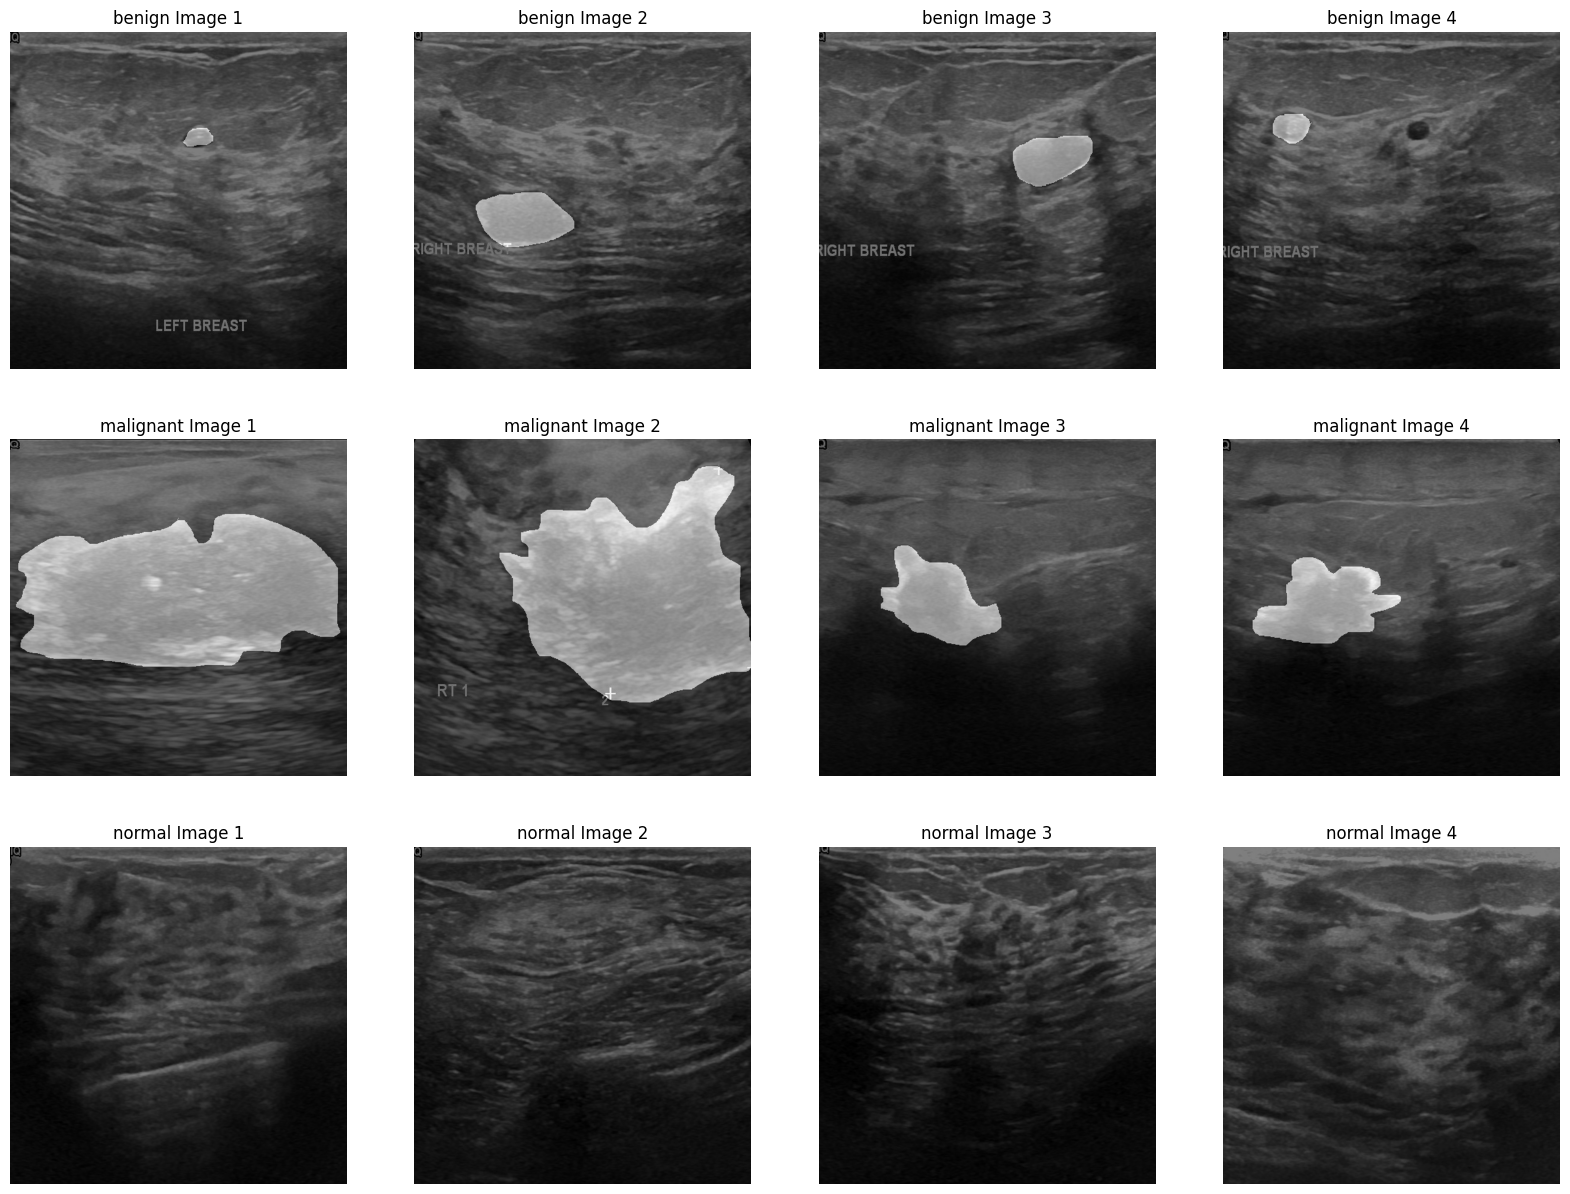

In [ ]:
# Set the path to the overlayed images directory
overlayed_dir = '/content/overlayed'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(overlayed_dir, label) for label in labels]

# Create a figure to display the images
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

# Desired width and height for each image
desired_width = 800  # Adjust as needed
desired_height = 800  # Adjust as needed

# Loop through each label and display the first 4 images
for i, label_dir in enumerate(label_dirs):
    # Get a list of image files and sort them
    images = [image for image in os.listdir(label_dir) if image.endswith('.png')]
    images.sort(key=lambda x: int(x.split('(')[1].split(')')[0]))  # Sort the images by number in parentheses

    for j, image_filename in enumerate(images[:4]):  # Display the first 4 images
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        # Resize the image to the desired width and height
        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

        # Display the image in the subplot
        axs[i, j].imshow(image)
        axs[i, j].set_title(f'{labels[i]} Image {j + 1}')
        axs[i, j].axis('off')

plt.show()

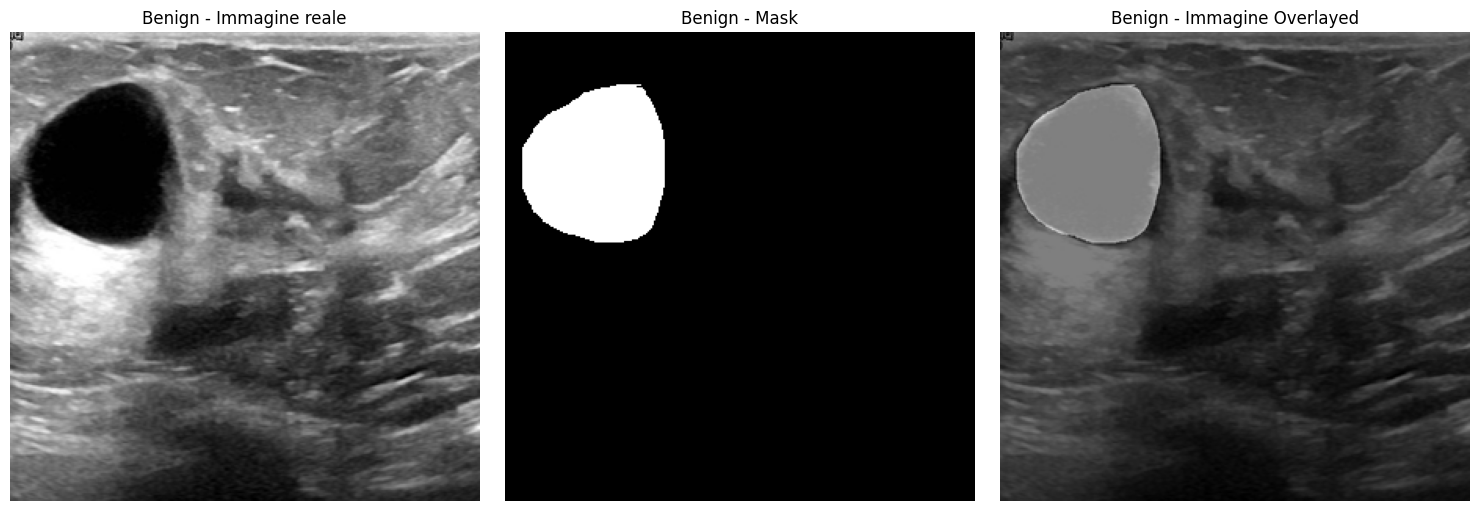

In [ ]:
# Define the directory paths
input_dir = '/content/Dataset_BUSI_with_GT'
overlayed_dir = '/content/overlayed/benign'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'benign (10).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'benign', image_filename)
mask_image_path = os.path.join(input_dir, 'benign', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('Benign - Immagine reale')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('Benign - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('Benign - Immagine Overlayed')
axs[2].axis('off')

plt.tight_layout()
plt.show()

## Train / Test split

Applicazione della funzione per suddivisione personalizzata in train e test per ogni categoria (benign, malignant, normal)

In [ ]:
# Immagini originarie - train / test split
custom_split_and_copy(SRC_BENIGN_FOLDER, NO_MASK_BENIGN_TRAIN_FOLDER, NO_MASK_BENIGN_TEST_FOLDER, split_ratio=0.5)
custom_split_and_copy(SRC_MALIGNANT_FOLDER, NO_MASK_MALIGNANT_TRAIN_FOLDER, NO_MASK_MALIGNANT_TEST_FOLDER, split_ratio=0.5)
custom_split_and_copy(SRC_NORMAL_FOLDER, NO_MASK_NORMAL_TRAIN_FOLDER, NO_MASK_NORMAL_TEST_FOLDER, split_ratio=0.5)

# Immagini overlayed - train / test split
custom_split_and_copy(OVERLAYED_BENIGN_FOLDER, WITH_MASK_BENIGN_TRAIN_FOLDER, WITH_MASK_BENIGN_TEST_FOLDER, split_ratio=0.5)
custom_split_and_copy(OVERLAYED_MALIGNANT_FOLDER, WITH_MASK_MALIGNANT_TRAIN_FOLDER, WITH_MASK_MALIGNANT_TEST_FOLDER, split_ratio=0.5)
custom_split_and_copy(OVERLAYED_NORMAL_FOLDER, WITH_MASK_NORMAL_TRAIN_FOLDER, WITH_MASK_NORMAL_TEST_FOLDER, split_ratio=0.5)

In [ ]:
# Original no_mask train / test
no_mask_benign_train_files = os.listdir("/content/no_mask/train/benign")
no_mask_malignant_train_files = os.listdir("/content/no_mask/train/malignant")
no_mask_normal_train_files = os.listdir("/content/no_mask/train/normal")

no_mask_benign_test_files = os.listdir("/content/no_mask/test/benign")
no_mask_malignant_test_files = os.listdir("/content/no_mask/test/malignant")
no_mask_normal_test_files = os.listdir("/content/no_mask/test/normal")

# Overlayed no_mask train / test
with_mask_benign_train_files = os.listdir("/content/with_mask/train/benign")
with_mask_malignant_train_files = os.listdir("/content/with_mask/train/malignant")
with_mask_normal_train_files = os.listdir("/content/with_mask/train/normal")

with_mask_benign_test_files = os.listdir("/content/with_mask/test/benign")
with_mask_malignant_test_files = os.listdir("/content/with_mask/test/malignant")
with_mask_normal_test_files = os.listdir("/content/with_mask/test/normal")

In [ ]:
# No_mask
# Benign - contare file original (no_mask)
print(f'Nella cartella "no_mask_benign_train_files" ci sono: {len(no_mask_benign_train_files)} immagini')
print(f'Nella cartella "no_mask_benign_test_files" ci sono: {len(no_mask_benign_test_files)} immagini')
# Malignant - contare file original (no_mask)
print(f'Nella cartella "no_mask_malignant_train_files" ci sono: {len(no_mask_malignant_train_files)} immagini')
print(f'Nella cartella "no_mask_malignant_test_files" ci sono: {len(no_mask_malignant_test_files)} immagini')
# Normal - contare file original (no_mask)
print(f'Nella cartella "no_mask_normal_train_files" ci sono: {len(no_mask_normal_train_files)} immagini')
print(f'Nella cartella "no_mask_normal_test_files" ci sono: {len(no_mask_normal_test_files)} immagini')

print('\n')

# With_mask (overlayed)
# Benign - contare file overlayed
print(f'Nella cartella "with_mask_benign_train_files" ci sono: {len(with_mask_benign_train_files)} immagini')
print(f'Nella cartella "with_mask_benign_test_files" ci sono: {len(with_mask_benign_test_files)} immagini')
# Malignant - contare file overlayed
print(f'Nella cartella "with_mask_malignant_train_files" ci sono: {len(with_mask_malignant_train_files)} immagini')
print(f'Nella cartella "with_mask_malignant_test_files" ci sono: {len(with_mask_malignant_test_files)} immagini')
# Normal - contare file overlayed
print(f'Nella cartella "with_mask_normal_train_files" ci sono: {len(with_mask_normal_train_files)} immagini')
print(f'Nella cartella "with_mask_normal_test_files" ci sono: {len(with_mask_normal_test_files)} immagini')

Nella cartella "no_mask_benign_train_files" ci sono: 218 immagini
Nella cartella "no_mask_benign_test_files" ci sono: 219 immagini
Nella cartella "no_mask_malignant_train_files" ci sono: 105 immagini
Nella cartella "no_mask_malignant_test_files" ci sono: 105 immagini
Nella cartella "no_mask_normal_train_files" ci sono: 66 immagini
Nella cartella "no_mask_normal_test_files" ci sono: 67 immagini


Nella cartella "with_mask_benign_train_files" ci sono: 218 immagini
Nella cartella "with_mask_benign_test_files" ci sono: 219 immagini
Nella cartella "with_mask_malignant_train_files" ci sono: 105 immagini
Nella cartella "with_mask_malignant_test_files" ci sono: 105 immagini
Nella cartella "with_mask_normal_train_files" ci sono: 66 immagini
Nella cartella "with_mask_normal_test_files" ci sono: 67 immagini


## Creazione dei datasets

In [ ]:
# common_seed = 12345

In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

common_seed = 42

# Imposta il seed per il modulo random
random.seed(common_seed)

# Imposta il seed per numpy
np.random.seed(common_seed)

# Imposta il seed per TensorFlow
tf.random.set_seed(common_seed)

In [ ]:
# Creazione dei dataset con immagini originarie
train_set_no_mask = image_dataset_from_directory("no_mask/train", image_size=(180, 180), batch_size=32, label_mode='categorical', labels='inferred', validation_split=0.2, subset="training", seed=common_seed)
val_set_no_mask = image_dataset_from_directory("no_mask/train", image_size=(180, 180), batch_size=32, label_mode='categorical', labels='inferred', validation_split=0.2, subset="training", seed=common_seed)
test_set_no_mask = image_dataset_from_directory("no_mask/test", image_size=(180, 180), batch_size=32, label_mode='categorical', labels='inferred', seed=common_seed)

# Creazione dei dataset con immagini overlayed
train_set_with_mask = image_dataset_from_directory("with_mask/train", image_size=(180, 180), batch_size=32, label_mode='categorical', validation_split=0.2, subset="training", seed=common_seed)
val_set_with_mask = image_dataset_from_directory("with_mask/train", image_size=(180, 180), batch_size=32, label_mode='categorical', validation_split=0.2, subset="training", seed=common_seed)
test_set_with_mask = image_dataset_from_directory("with_mask/test", image_size=(180, 180), batch_size=32, label_mode='categorical', seed=common_seed)

Found 389 files belonging to 3 classes.
Using 312 files for training.
Found 389 files belonging to 3 classes.
Using 312 files for training.
Found 391 files belonging to 3 classes.
Found 389 files belonging to 3 classes.
Using 312 files for training.
Found 389 files belonging to 3 classes.
Using 312 files for training.
Found 391 files belonging to 3 classes.


## Data Augmentation con Albumentations

In [ ]:
!pip install albumentations

In [ ]:
# Creazione del modello con Augmentation
data_augmentation = Sequential(
    [
        Input(shape=(180, 180)),
        RandomFlip('horizontal', seed=common_seed),
        RandomRotation(0.1, seed=common_seed),
        RandomZoom(0.1, seed=common_seed),
        # RandomContrast(0.1, seed=common_seed),
        # RandomBrightness(0.1, seed=common_seed),
        # RandomCrop(180,180, seed=common_seed)
    ]
)

## Download modelli pre-addestrati per Transfer Learning

In [ ]:
# Download modello VGG16 (no re-training)
vgg16_net = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(180, 180, 3))
vgg16_net.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
# Download modello ResNet101 (no re-training)
ResNet101_net = ResNet101(include_top=False, weights='imagenet', input_shape=(180, 180, 3))
ResNet101_net.trainable = False

171446536/171446536 [==============================] - 8s 0us/step


# 1 . Transfer Learning original

## Augmentation

In [ ]:
# Modo alternativo: L'aumentazione viene fatta nel dataset e non dal modello
augmented_dataset_original = test_set_no_mask.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
x_batch, y_batch = next(iter(train_set_no_mask))

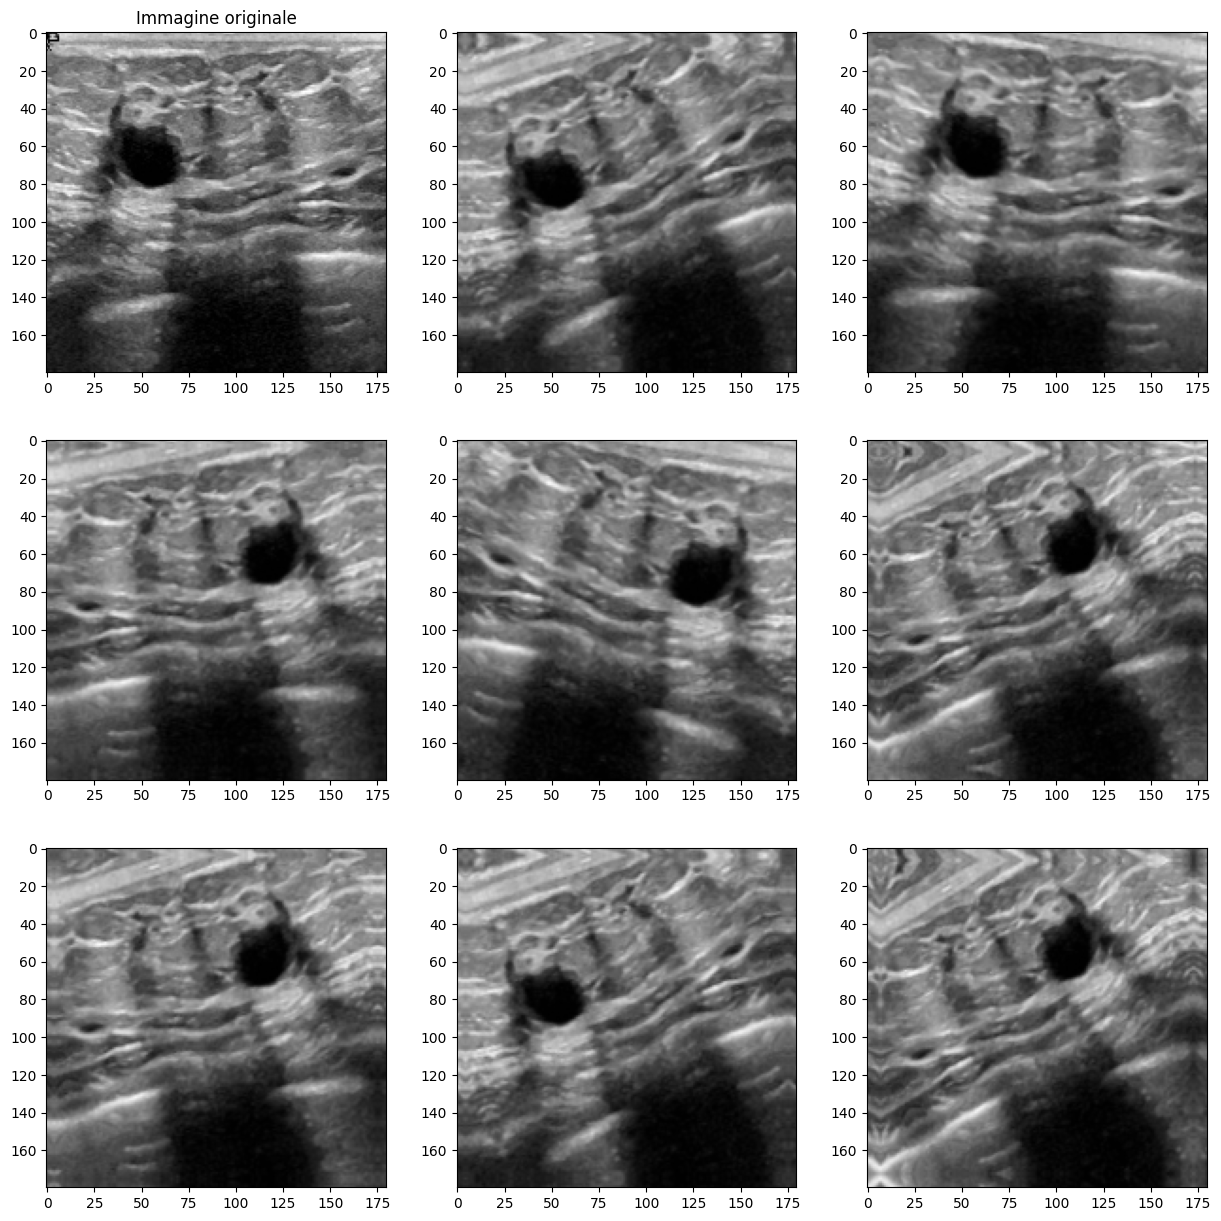

In [ ]:
show_augmetation_results(3, 3, x_batch[1]/255)

## 1.1. VGG16 - Creazone e compilazione modello, Setting Callbacks

In [ ]:
# Creazione del modello con data augmentation
vgg16_augmentation_original = Sequential([
    Input(shape=(180, 180, 3)),
    data_augmentation,
    Lambda(preprocess_input),
    vgg16_net,
    Flatten(),
    Dense(256, 'relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compilazione del modello
vgg16_augmentation_original.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Setting Callbacks
csv_logger_vgg16_augmentation_original = CSVLogger('logger_vgg16_augmentation_original.csv')
checkpoint_vgg16_augmentation_original = ModelCheckpoint('checkpoint_vgg16_augmentation_original')
early_stopping_vgg16_augmentation_original = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
vgg16_augmentation_original.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180)          0         
                                                                 
 lambda (Lambda)             (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                

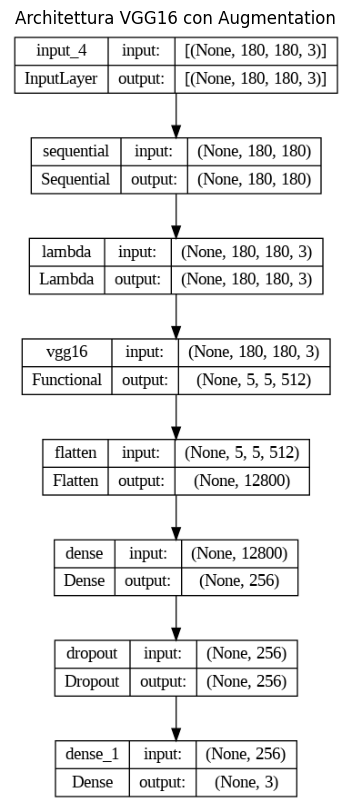

In [ ]:
plot_model(model=vgg16_augmentation_original, show_shapes=True, to_file='model_1.png')

image = plt.imread('model_1.png')

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title('Architettura VGG16 con Augmentation')
plt.axis('off')
plt.savefig('model_1_VGG16.png')
plt.show()

### Addestramento modello

In [ ]:
vgg16_augmentation_original.fit(
    x=train_set_no_mask,
    epochs=100,
    validation_data=val_set_no_mask,
    callbacks=[csv_logger_vgg16_augmentation_original, checkpoint_vgg16_augmentation_original, early_stopping_vgg16_augmentation_original]
)

Epoch 1/100
10/10 [==============================] - 28s 1s/step - loss: 10.0452 - accuracy: 0.5513 - val_loss: 2.4005 - val_accuracy: 0.6795
Epoch 2/100
10/10 [==============================] - 9s 824ms/step - loss: 2.6605 - accuracy: 0.6635 - val_loss: 1.0289 - val_accuracy: 0.7821
Epoch 3/100
10/10 [==============================] - 8s 714ms/step - loss: 1.2918 - accuracy: 0.7212 - val_loss: 0.7874 - val_accuracy: 0.7756
Epoch 4/100
10/10 [==============================] - 9s 784ms/step - loss: 0.9184 - accuracy: 0.7147 - val_loss: 0.4097 - val_accuracy: 0.8462
Epoch 5/100
10/10 [==============================] - 9s 815ms/step - loss: 0.6077 - accuracy: 0.7404 - val_loss: 0.3540 - val_accuracy: 0.8526
Epoch 6/100
10/10 [==============================] - 9s 783ms/step - loss: 0.6632 - accuracy: 0.7532 - val_loss: 0.3671 - val_accuracy: 0.8558
Epoch 7/100
10/10 [==============================] - 8s 748ms/step - loss: 0.5855 - accuracy: 0.7500 - val_loss: 0.3716 - val_accuracy: 0.8654


In [ ]:
# dizionario che contiene la storia dell'addestramento: ha diverse chiavi in questo caso sono 4: loss, accuracy, val_loss, val_accuracy
h = vgg16_augmentation_original.history.history

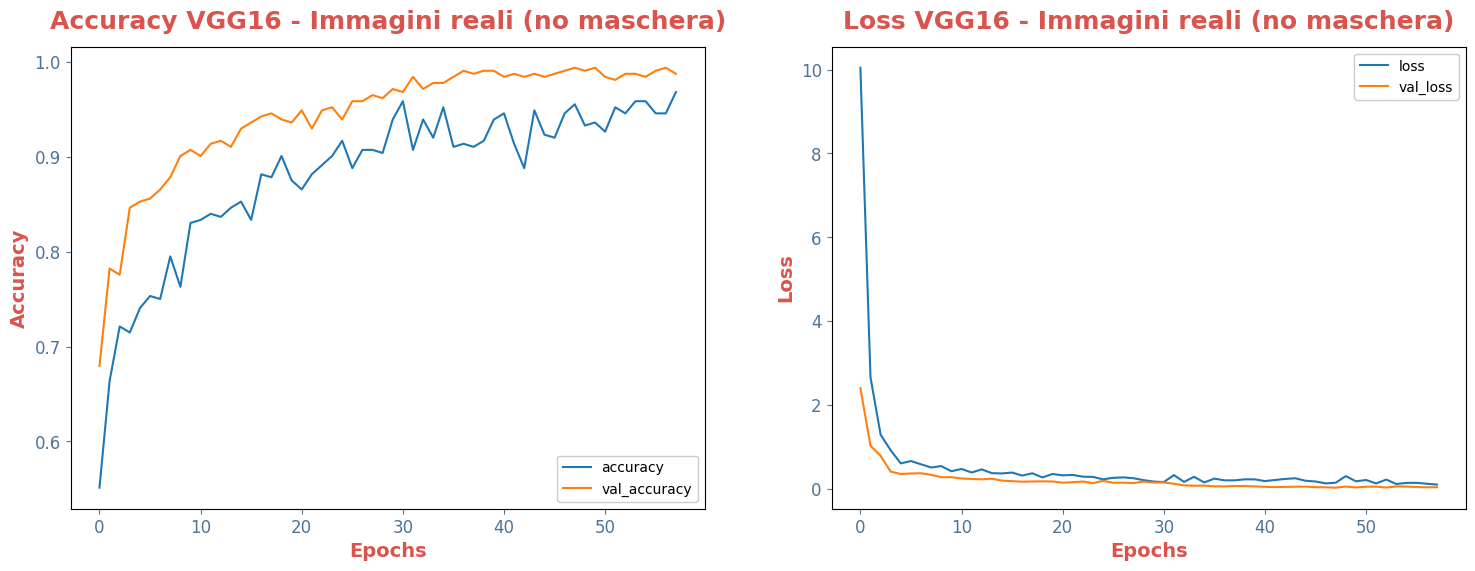

In [ ]:
loss = h['loss']
val_loss = h['val_loss']
accuracy = h['accuracy']
val_accuracy = h['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(accuracy, label='accuracy')
ax[0].plot(val_accuracy, label='val_accuracy')
ax[0].legend()
ax[0].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1, loc='lower right')
nice_plotting(ax[0], title='Accuracy VGG16 - Immagini reali (no maschera)', xlabel='Epochs', ylabel='Accuracy', new_fig=False, figsize=(10, 6))

ax[1].plot(loss, label='loss')
ax[1].plot(val_loss, label='val_loss')
ax[1].legend()
ax[1].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1)
nice_plotting(ax[1], title='Loss VGG16 - Immagini reali (no maschera)', xlabel='Epochs', ylabel='Loss', new_fig=False, figsize=(10, 6))

plt.savefig('Train_VGG16_Real_Images.png')
plt.show()

### Valutazione del modello

In [ ]:
vgg16_augmentation_original.evaluate(x=test_set_no_mask)

13/13 [==============================] - 6s 266ms/step - loss: 0.5471 - accuracy: 0.8261


[0.5471007227897644, 0.8260869383811951]

### Confusion matrix

In [ ]:
# Ottenere le etichette reali e previste per il set di test con maschera
true_labels, predicted_labels = get_true_and_predicted_labels(vgg16_augmentation_original, test_set_no_mask)

# Calcolare la confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

1/1 [==============================] - 0s 175ms/step


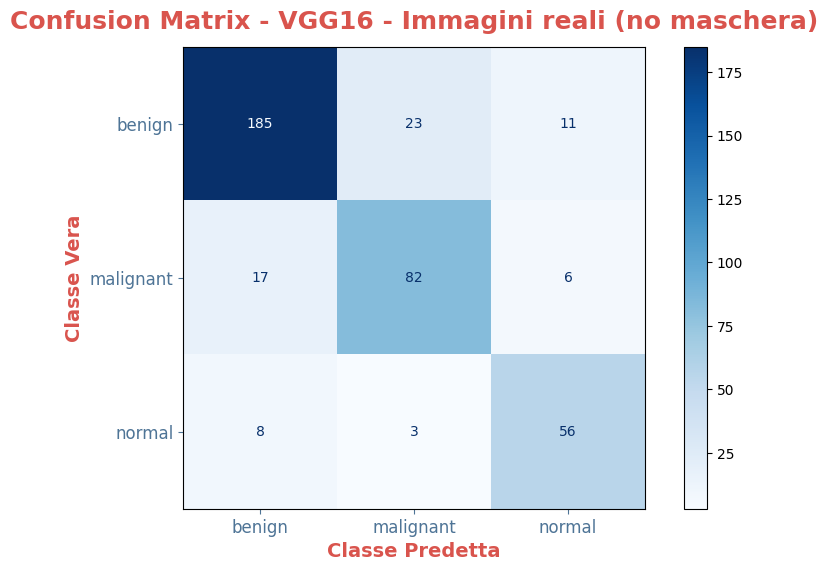

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign", "malignant", "normal"])

fig, ax = plt.subplots(figsize=(10, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.set_title("Confusion Matrix - VGG16 - Immagini reali (no maschera)", color='xkcd:pale red', fontsize=18, pad=13, fontweight='bold')
ax.set_xlabel("Classe Predetta", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.set_ylabel("Classe Vera", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', labelsize=12, colors='xkcd:cadet blue')
ax.tick_params(axis='y', labelsize=12, colors='xkcd:cadet blue')

plt.savefig('Confusion_Matrix_VGG16_Real_Images.png')
plt.show()

In [ ]:
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
class_report = classification_report(true_labels, predicted_labels, target_names=["benign", "malignant", "normal"])
f2_score = fbeta_score(true_labels, predicted_labels, beta=2, average='weighted')
class_report_with_f2 = f"{class_report}\n\nF2-Score: {f2_score}"

print("\033[1m\033[91mClassification Report - VGG16 - Immagini reali (no maschera):\033[0m\033[0m")
print(class_report_with_f2)

Classification Report - VGG16 - Immagini reali (no maschera):
              precision    recall  f1-score   support

      benign       0.88      0.84      0.86       219
   malignant       0.76      0.78      0.77       105
      normal       0.77      0.84      0.80        67

    accuracy                           0.83       391
   macro avg       0.80      0.82      0.81       391
weighted avg       0.83      0.83      0.83       391


F2-Score: 0.8262964266929921


## 1.2. ResNet101 - Creazone e compilazione modello, Setting Callbacks

In [ ]:
# Creazione del modello con data augmentation
ResNet101_augmentation_original = Sequential([
    Input(shape=(180, 180, 3)),
    data_augmentation,
    Lambda(preprocess_input),
    ResNet101_net,
    Flatten(),
    Dense(256, 'relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compilazione del modello
ResNet101_augmentation_original.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Setting Callbacks
csv_logger_ResNet101_augmentation_original = CSVLogger('logger_resnet101_augmentation_original.csv')
checkpoint_ResNet101_augmentation_original = ModelCheckpoint('checkpoint_resnet101_augmentation_original')
early_stopping_ResNet101_augmentation_original = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
ResNet101_augmentation_original.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180)          0         
                                                                 
 lambda_1 (Lambda)           (None, 180, 180, 3)       0         
                                                                 
 resnet101 (Functional)      (None, 6, 6, 2048)        42658176  
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               18874624  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                

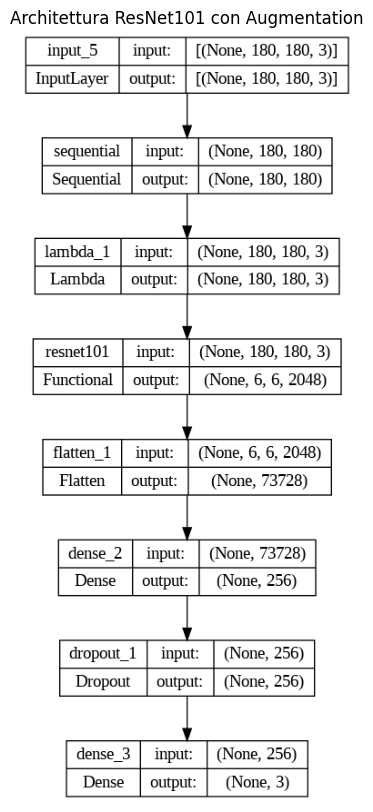

In [ ]:
plot_model(model=ResNet101_augmentation_original, show_shapes=True, to_file='model_2.png')

image = plt.imread('model_2.png')

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title('Architettura ResNet101 con Augmentation')
plt.axis('off')
plt.savefig('model_2_ResNet101.png')
plt.show()

### Addestramento modello

In [ ]:
ResNet101_augmentation_original.fit(
    x=train_set_no_mask,
    epochs=100,
    validation_data=val_set_no_mask,
    callbacks=[csv_logger_ResNet101_augmentation_original, checkpoint_ResNet101_augmentation_original, early_stopping_ResNet101_augmentation_original]
)

Epoch 1/100
10/10 [==============================] - 55s 5s/step - loss: 23.5401 - accuracy: 0.5192 - val_loss: 5.1946 - val_accuracy: 0.6923
Epoch 2/100
10/10 [==============================] - 42s 5s/step - loss: 10.5699 - accuracy: 0.6186 - val_loss: 3.9428 - val_accuracy: 0.7179
Epoch 3/100
10/10 [==============================] - 42s 5s/step - loss: 6.5763 - accuracy: 0.6506 - val_loss: 1.4971 - val_accuracy: 0.7917
Epoch 4/100
10/10 [==============================] - 44s 5s/step - loss: 1.1501 - accuracy: 0.7468 - val_loss: 0.6156 - val_accuracy: 0.7692
Epoch 5/100
10/10 [==============================] - 43s 5s/step - loss: 0.6675 - accuracy: 0.7276 - val_loss: 0.4967 - val_accuracy: 0.8237
Epoch 6/100
10/10 [==============================] - 45s 5s/step - loss: 0.7183 - accuracy: 0.7115 - val_loss: 0.5251 - val_accuracy: 0.8269
Epoch 7/100
10/10 [==============================] - 43s 5s/step - loss: 0.7232 - accuracy: 0.7628 - val_loss: 0.4422 - val_accuracy: 0.8462
Epoch 8/100

In [ ]:
# dizionario che contiene la storia dell'addestramento: ha diverse chiavi in questo caso sono 4: loss, accuracy, val_loss, val_accuracy
h = ResNet101_augmentation_original.history.history

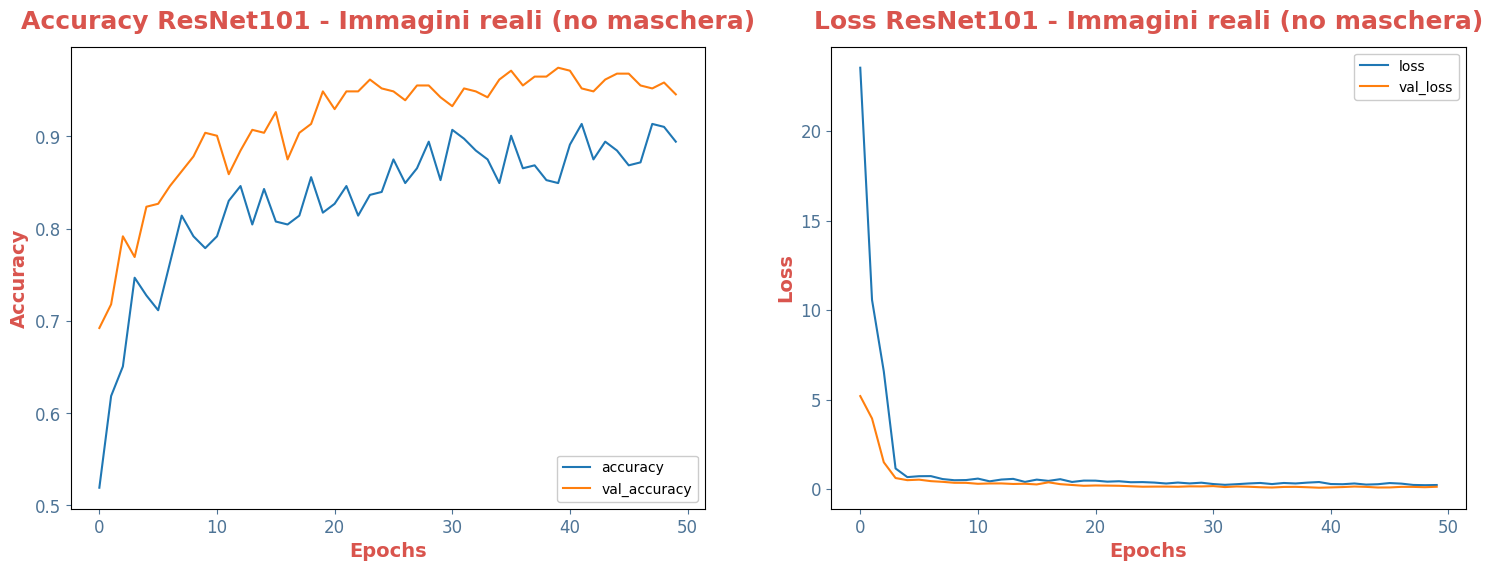

In [ ]:
loss = h['loss']
val_loss = h['val_loss']
accuracy = h['accuracy']
val_accuracy = h['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(accuracy, label='accuracy')
ax[0].plot(val_accuracy, label='val_accuracy')
ax[0].legend()
ax[0].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1, loc='lower right')
nice_plotting(ax[0], title='Accuracy ResNet101 - Immagini reali (no maschera)', xlabel='Epochs', ylabel='Accuracy', new_fig=False, figsize=(10, 6))

ax[1].plot(loss, label='loss')
ax[1].plot(val_loss, label='val_loss')
ax[1].legend()
ax[1].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1)
nice_plotting(ax[1], title='Loss ResNet101 - Immagini reali (no maschera)', xlabel='Epochs', ylabel='Loss', new_fig=False, figsize=(10, 6))

plt.savefig('Train_ResNet101_Real_Images.png')
plt.show()

### Valutazione del modello

In [ ]:
ResNet101_augmentation_original.evaluate(x=test_set_no_mask)

13/13 [==============================] - 4s 194ms/step - loss: 0.5200 - accuracy: 0.8517


[0.5200087428092957, 0.8516623973846436]

### Confusion matrix

In [ ]:
# Ottenere le etichette reali e previste per il set di test con maschera
true_labels, predicted_labels = get_true_and_predicted_labels(ResNet101_augmentation_original, test_set_no_mask)

# Calcolare la confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

1/1 [==============================] - 2s 2s/step


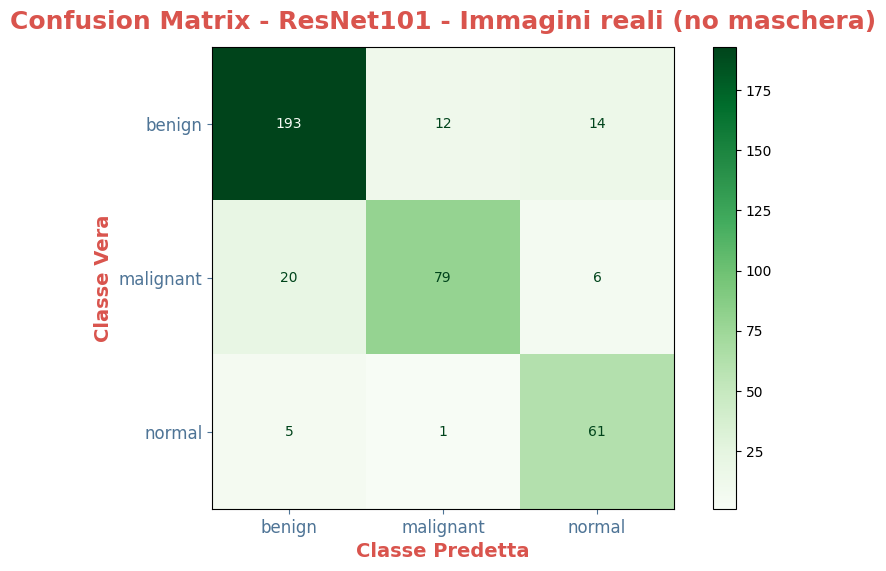

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign", "malignant", "normal"])

fig, ax = plt.subplots(figsize=(10, 6))
disp.plot(cmap='Greens', values_format='d', ax=ax)
ax.set_title("Confusion Matrix - ResNet101 - Immagini reali (no maschera)", color='xkcd:pale red', fontsize=18, pad=13, fontweight='bold')
ax.set_xlabel("Classe Predetta", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.set_ylabel("Classe Vera", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', labelsize=12, colors='xkcd:cadet blue')
ax.tick_params(axis='y', labelsize=12, colors='xkcd:cadet blue')

plt.savefig('Confusion_Matrix_ResNet101_Real_Images.png')
plt.show()

In [ ]:
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
class_report = classification_report(true_labels, predicted_labels, target_names=["benign", "malignant", "normal"])
f2_score = fbeta_score(true_labels, predicted_labels, beta=2, average='weighted')
class_report_with_f2 = f"{class_report}\n\nF2-Score: {f2_score}"

print("\033[1m\033[91mClassification Report - ResNet101 - Immagini reali (no maschera):\033[0m\033[0m")
print(class_report_with_f2)

Classification Report - ResNet101 - Immagini reali (no maschera):
              precision    recall  f1-score   support

      benign       0.89      0.88      0.88       219
   malignant       0.86      0.75      0.80       105
      normal       0.75      0.91      0.82        67

    accuracy                           0.85       391
   macro avg       0.83      0.85      0.84       391
weighted avg       0.86      0.85      0.85       391


F2-Score: 0.8509853830946328


  # 2 . Transfer Learning overlayed

## Augmentation

In [ ]:
# Modo alternativo: L'aumentazione viene fatta nel dataset e non dal modello
augmented_dataset_overlayed = test_set_with_mask.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
x_batch, y_batch = next(iter(train_set_with_mask))

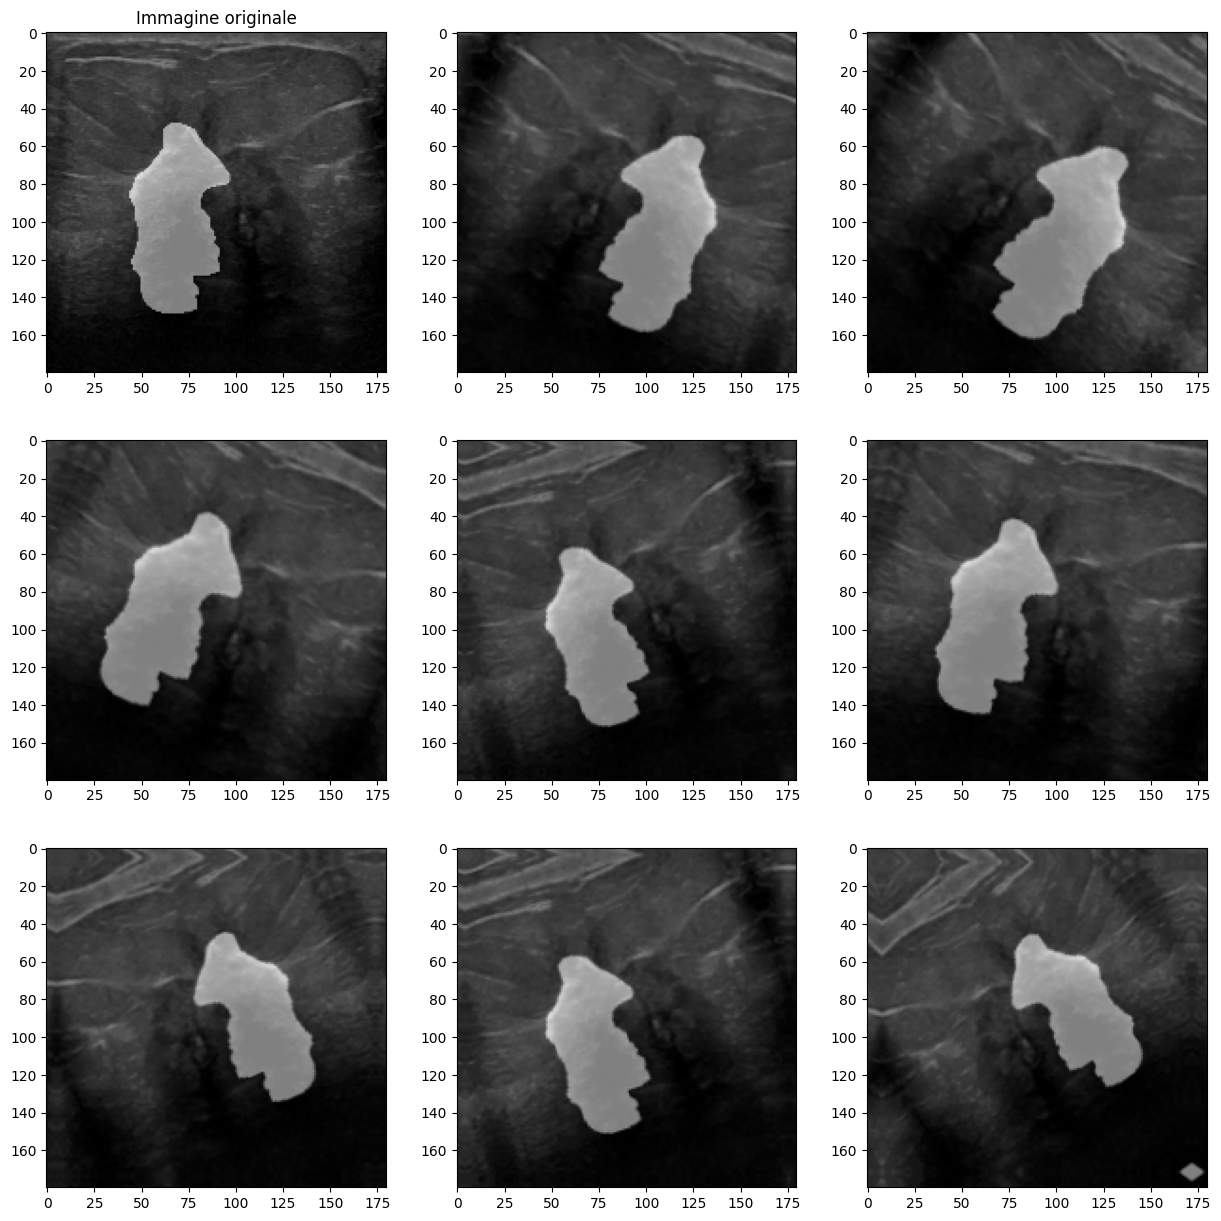

In [ ]:
show_augmetation_results(3, 3, x_batch[2]/255)

## 2.1. VGG16 - Creazone e compilazione modello, Setting Callbacks

In [ ]:
# Creazione del modello con data augmentation
vgg16_augmentation_overlayed = Sequential([
    Input(shape=(180, 180, 3)),
    data_augmentation,
    Lambda(preprocess_input),
    vgg16_net,
    Flatten(),
    Dense(256, 'relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compilazione del modello
vgg16_augmentation_overlayed.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Setting Callbacks
csv_logger_vgg16_augmentation_overlayed = CSVLogger('logger_vgg16_augmentation_overlayed.csv')
checkpoint_vgg16_augmentation_overlayed = ModelCheckpoint('checkpoint_vgg16_augmentation_overlayed')
early_stopping_vgg16_augmentation_overlayed = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
vgg16_augmentation_overlayed.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180)          0         
                                                                 
 lambda_2 (Lambda)           (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                

### Addestramento modello

In [ ]:
vgg16_augmentation_overlayed.fit(
    x=train_set_with_mask,
    epochs=100,
    validation_data=val_set_with_mask,
    callbacks=[csv_logger_vgg16_augmentation_overlayed, checkpoint_vgg16_augmentation_overlayed, early_stopping_vgg16_augmentation_overlayed]
)

Epoch 1/100
10/10 [==============================] - 13s 1s/step - loss: 9.8337 - accuracy: 0.6026 - val_loss: 1.1725 - val_accuracy: 0.8782
Epoch 2/100
10/10 [==============================] - 10s 903ms/step - loss: 1.3677 - accuracy: 0.8558 - val_loss: 0.5588 - val_accuracy: 0.9455
Epoch 3/100
10/10 [==============================] - 9s 843ms/step - loss: 0.9599 - accuracy: 0.8814 - val_loss: 0.3300 - val_accuracy: 0.9391
Epoch 4/100
10/10 [==============================] - 10s 922ms/step - loss: 0.5921 - accuracy: 0.9199 - val_loss: 0.3747 - val_accuracy: 0.9583
Epoch 5/100
10/10 [==============================] - 9s 773ms/step - loss: 0.4834 - accuracy: 0.9295 - val_loss: 0.1347 - val_accuracy: 0.9647
Epoch 6/100
10/10 [==============================] - 10s 908ms/step - loss: 0.3515 - accuracy: 0.9263 - val_loss: 0.0820 - val_accuracy: 0.9647
Epoch 7/100
10/10 [==============================] - 10s 945ms/step - loss: 0.1868 - accuracy: 0.9391 - val_loss: 0.0944 - val_accuracy: 0.96

In [ ]:
# dizionario che contiene la storia dell'addestramento: ha diverse chiavi in questo caso sono 4: loss, accuracy, val_loss, val_accuracy
h = vgg16_augmentation_overlayed.history.history

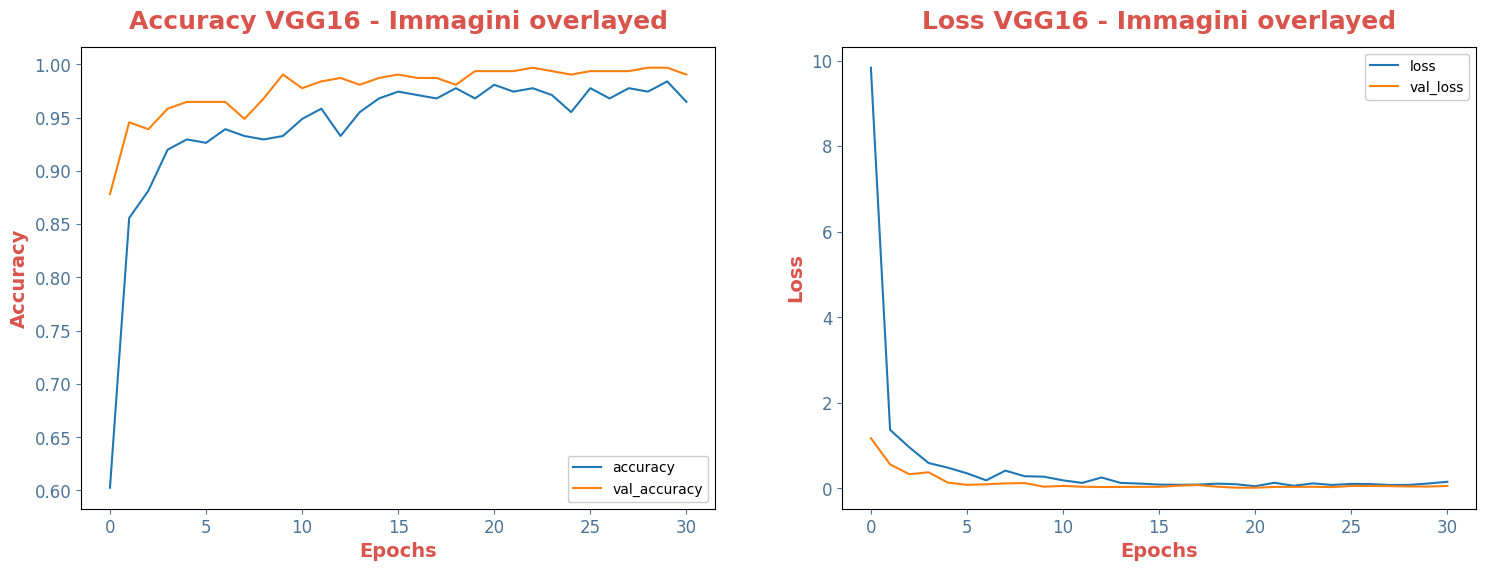

In [ ]:
loss = h['loss']
val_loss = h['val_loss']
accuracy = h['accuracy']
val_accuracy = h['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(accuracy, label='accuracy')
ax[0].plot(val_accuracy, label='val_accuracy')
ax[0].legend()
ax[0].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1, loc='lower right')
nice_plotting(ax[0], title='Accuracy VGG16 - Immagini overlayed', xlabel='Epochs', ylabel='Accuracy', new_fig=False, figsize=(10, 6))

ax[1].plot(loss, label='loss')
ax[1].plot(val_loss, label='val_loss')
ax[1].legend()
ax[1].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1)
nice_plotting(ax[1], title='Loss VGG16 - Immagini overlayed', xlabel='Epochs', ylabel='Loss', new_fig=False, figsize=(10, 6))

plt.savefig('Train_VGG16_Overalyed_Images.png')
plt.show()

### Valutazione del modello

In [ ]:
vgg16_augmentation_overlayed.evaluate(x=test_set_with_mask)

13/13 [==============================] - 3s 113ms/step - loss: 0.1824 - accuracy: 0.9719


[0.1823764592409134, 0.971867024898529]

### Confusion matrix

In [ ]:
# Ottenere le etichette reali e previste per il set di test con maschera
true_labels, predicted_labels = get_true_and_predicted_labels(vgg16_augmentation_overlayed, test_set_with_mask)

# Calcolare la confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

1/1 [==============================] - 0s 163ms/step


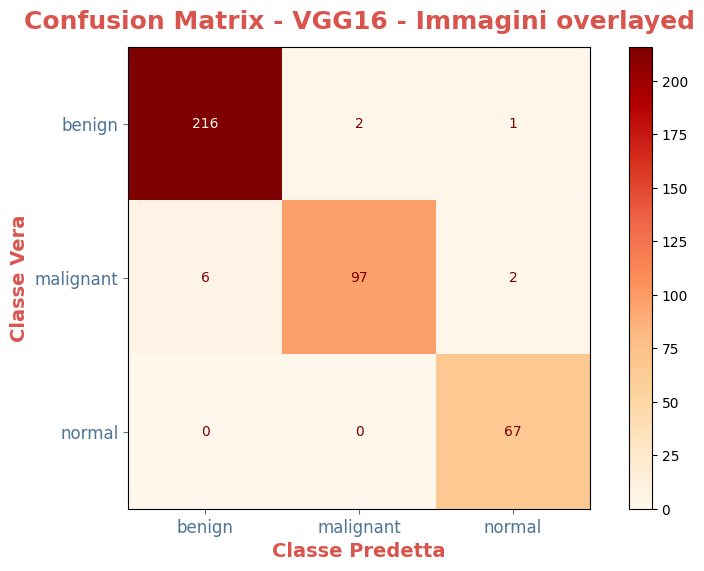

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign", "malignant", "normal"])

fig, ax = plt.subplots(figsize=(10, 6))
disp.plot(cmap='OrRd', values_format='d', ax=ax)
ax.set_title("Confusion Matrix - VGG16 - Immagini overlayed", color='xkcd:pale red', fontsize=18, pad=13, fontweight='bold')
ax.set_xlabel("Classe Predetta", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.set_ylabel("Classe Vera", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', labelsize=12, colors='xkcd:cadet blue')
ax.tick_params(axis='y', labelsize=12, colors='xkcd:cadet blue')

plt.savefig('Confusion_Matrix_VGG16_Overlayed_Images.png')
plt.show()

In [ ]:
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
class_report = classification_report(true_labels, predicted_labels, target_names=["benign", "malignant", "normal"])
f2_score = fbeta_score(true_labels, predicted_labels, beta=2, average='weighted')
class_report_with_f2 = f"{class_report}\n\nF2-Score: {f2_score}"

print("\033[1m\033[91mClassification Report - VGG16 - Immagini overlayed:\033[0m\033[0m")
print(class_report_with_f2)

Classification Report - VGG16 - Immagini overlayed:
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98       219
   malignant       0.98      0.92      0.95       105
      normal       0.96      1.00      0.98        67

    accuracy                           0.97       391
   macro avg       0.97      0.97      0.97       391
weighted avg       0.97      0.97      0.97       391


F2-Score: 0.9717047283698153


## 2.2. ResNet101 - Creazone e compilazione modello, Setting Callbacks

In [ ]:
# Download modello ResNet101 (no re-training)
ResNet101_net = ResNet101(include_top=False, weights='imagenet', input_shape=(180, 180, 3))
ResNet101_net.trainable = False

# Creazione del modello con data augmentation
ResNet101_augmentation_overlayed = Sequential([
    Input(shape=(180, 180, 3)),
    data_augmentation,
    Lambda(preprocess_input),
    ResNet101_net,
    Flatten(),
    Dense(256, 'relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compilazione del modello
ResNet101_augmentation_overlayed.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Setting Callbacks
csv_logger_ResNet101_augmentation_overlayed = CSVLogger('logger_resnet101_augmentation_overlayed.csv')
checkpoint_ResNet101_augmentation_overlayed = ModelCheckpoint('checkpoint_resnet101_augmentation_overlayed')
early_stopping_ResNet101_augmentation_overlayed = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
ResNet101_augmentation_overlayed.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180)          0         
                                                                 
 lambda_3 (Lambda)           (None, 180, 180, 3)       0         
                                                                 
 resnet101 (Functional)      (None, 6, 6, 2048)        42658176  
                                                                 
 flatten_3 (Flatten)         (None, 73728)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               18874624  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                

### Addestramento modello

In [ ]:
ResNet101_augmentation_overlayed.fit(
    x=train_set_with_mask,
    epochs=100,
    validation_data=val_set_with_mask,
    callbacks=[csv_logger_ResNet101_augmentation_overlayed, checkpoint_ResNet101_augmentation_overlayed, early_stopping_ResNet101_augmentation_overlayed]
)

Epoch 1/100
10/10 [==============================] - 57s 5s/step - loss: 13.5391 - accuracy: 0.6410 - val_loss: 1.7619 - val_accuracy: 0.9519
Epoch 2/100
10/10 [==============================] - 48s 5s/step - loss: 6.2214 - accuracy: 0.8462 - val_loss: 1.8997 - val_accuracy: 0.9615
Epoch 3/100
10/10 [==============================] - 46s 5s/step - loss: 3.4088 - accuracy: 0.9391 - val_loss: 1.3055 - val_accuracy: 0.9231
Epoch 4/100
10/10 [==============================] - 48s 5s/step - loss: 2.2043 - accuracy: 0.9167 - val_loss: 0.7160 - val_accuracy: 0.9712
Epoch 5/100
10/10 [==============================] - 49s 5s/step - loss: 1.2798 - accuracy: 0.9423 - val_loss: 0.2866 - val_accuracy: 0.9872
Epoch 6/100
10/10 [==============================] - 46s 5s/step - loss: 0.8085 - accuracy: 0.9199 - val_loss: 0.4614 - val_accuracy: 0.9712
Epoch 7/100
10/10 [==============================] - 48s 5s/step - loss: 1.1572 - accuracy: 0.9295 - val_loss: 0.2217 - val_accuracy: 0.9872
Epoch 8/100


In [ ]:
# dizionario che contiene la storia dell'addestramento: ha diverse chiavi in questo caso sono 4: loss, accuracy, val_loss, val_accuracy
h = ResNet101_augmentation_overlayed.history.history

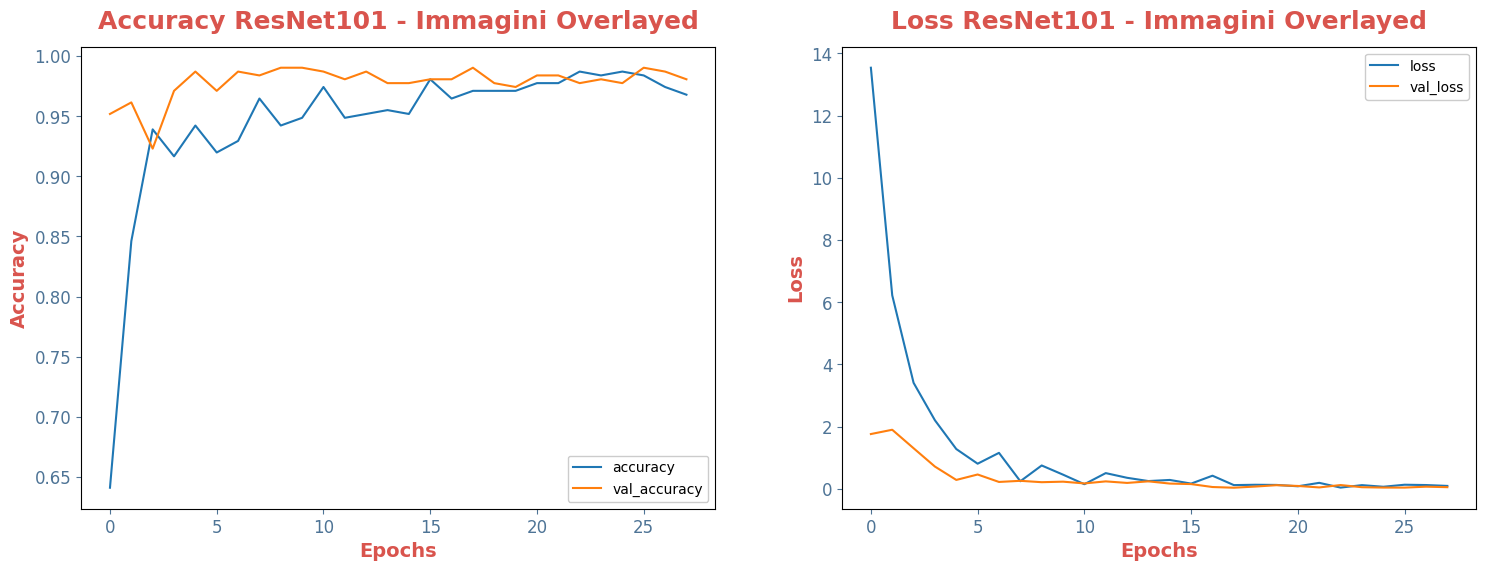

In [ ]:
loss = h['loss']
val_loss = h['val_loss']
accuracy = h['accuracy']
val_accuracy = h['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(accuracy, label='accuracy')
ax[0].plot(val_accuracy, label='val_accuracy')
ax[0].legend()
ax[0].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1, loc='lower right')
nice_plotting(ax[0], title='Accuracy ResNet101 - Immagini Overlayed', xlabel='Epochs', ylabel='Accuracy', new_fig=False, figsize=(10, 6))

ax[1].plot(loss, label='loss')
ax[1].plot(val_loss, label='val_loss')
ax[1].legend()
ax[1].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1)
nice_plotting(ax[1], title='Loss ResNet101 - Immagini Overlayed', xlabel='Epochs', ylabel='Loss', new_fig=False, figsize=(10, 6))

plt.savefig('Train_ResNet101_Overlayed_Images.png')
plt.show()

### Valutazione del modello

In [ ]:
ResNet101_augmentation_overlayed.evaluate(x=test_set_with_mask)

13/13 [==============================] - 3s 126ms/step - loss: 0.5286 - accuracy: 0.9540


[0.5285953879356384, 0.9539641737937927]

### Confusion matrix

In [ ]:
# Ottenere le etichette reali e previste per il set di test con maschera
true_labels, predicted_labels = get_true_and_predicted_labels(ResNet101_augmentation_overlayed, test_set_with_mask)

# Calcolare la confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

1/1 [==============================] - 2s 2s/step


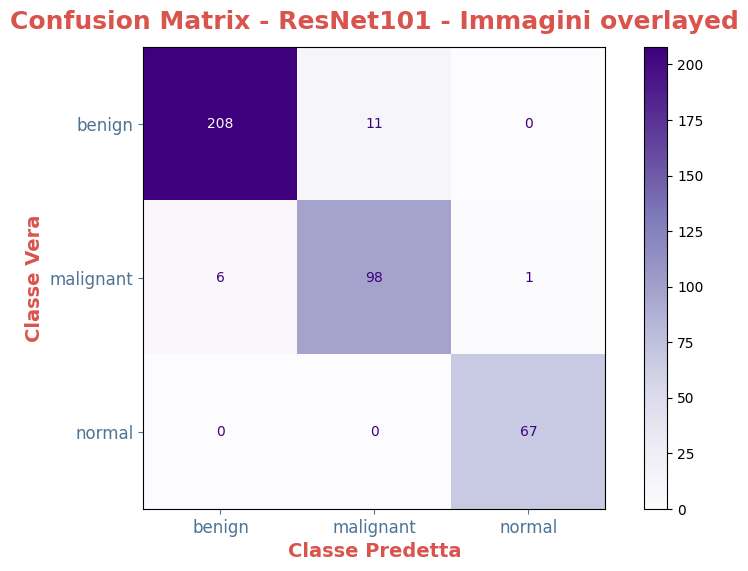

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign", "malignant", "normal"])

fig, ax = plt.subplots(figsize=(10, 6))
disp.plot(cmap='Purples', values_format='d', ax=ax)
ax.set_title("Confusion Matrix - ResNet101 - Immagini overlayed", color='xkcd:pale red', fontsize=18, pad=13, fontweight='bold')
ax.set_xlabel("Classe Predetta", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.set_ylabel("Classe Vera", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', labelsize=12, colors='xkcd:cadet blue')
ax.tick_params(axis='y', labelsize=12, colors='xkcd:cadet blue')

plt.savefig('Confusion_Matrix_ResNet101_Overlayed_Images.png')
plt.show()

In [ ]:
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
class_report = classification_report(true_labels, predicted_labels, target_names=["benign", "malignant", "normal"])
f2_score = fbeta_score(true_labels, predicted_labels, beta=2, average='weighted')
class_report_with_f2 = f"{class_report}\n\nF2-Score: {f2_score}"

print("\033[1m\033[91mClassification Report - ResNet101 - Immagini overlayed:\033[0m\033[0m")
print(class_report_with_f2)

Classification Report - ResNet101 - Immagini overlayed:
              precision    recall  f1-score   support

      benign       0.97      0.95      0.96       219
   malignant       0.90      0.93      0.92       105
      normal       0.99      1.00      0.99        67

    accuracy                           0.95       391
   macro avg       0.95      0.96      0.96       391
weighted avg       0.95      0.95      0.95       391


F2-Score: 0.9539992401138397
